In [1]:
import os
import zipfile

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Imputation libraries
import scprep # preprocessing
import saver
import magic
import scanpy as sc

from scipy.stats import spearmanr

# Clustering libraries
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score

/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 0: Download the training data

In [2]:
path_data = "data/"
results_path = "results"
archive_name = "CarballoCastro_Alba.zip"

In [3]:
bulk_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).set_index("level_0")
sc_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).set_index("Unnamed: 0")
sc_pancreas_metadata = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_metadata_train.csv")).set_index("Source Name")

sc_pancreas_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).set_index("Unnamed: 0")
sc_pancreas_metadata_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_metadata_test_wocelltype.csv")).set_index("Source Name")

In [4]:
print(f"Number of patients in the train dataset {bulk_pancreas.shape[1]}")
print(f"Number of genes in the dataset {bulk_pancreas.shape[0]}")

assert bulk_pancreas.shape[0] == sc_pancreas.shape[0]
print(f"Number of cells in the train dataset {sc_pancreas.shape[1]}")

Number of patients in the train dataset 4
Number of genes in the dataset 25453
Number of cells in the train dataset 978


In [5]:
print(f"Number of cells in the test dataset {sc_pancreas_test.shape[1]}")

Number of cells in the test dataset 789


In [6]:
for patient in sc_pancreas_metadata.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata[sc_pancreas_metadata.Sample==patient].shape[0]}")

Number of cells for patient1 is 249
Number of cells for patient3 is 219
Number of cells for patient2 is 234
Number of cells for patient4 is 276


In [7]:
for dis in sc_pancreas_metadata.Disease.unique():
    df = sc_pancreas_metadata[sc_pancreas_metadata.Disease==dis]
    print(f"There are {df.Sample.nunique()} train patients with {dis}")

There are 2 train patients with type II diabetes mellitus
There are 2 train patients with normal


In [8]:
print(f"There are {sc_pancreas_metadata.Celltype.nunique()} different cell types in the dataset")
print(f"The different cells types are {sc_pancreas_metadata.Celltype.unique()}")

There are 13 different cell types in the dataset
The different cells types are ['acinar cell' 'alpha cell' 'gamma cell' 'delta cell'
 'unclassified endocrine cell' 'beta cell' 'ductal cell'
 'endothelial cell' 'co-expression cell' 'PSC cell' 'epsilon cell'
 'MHC class II cell' 'mast cell']


In [9]:
for patient in sc_pancreas_metadata_test.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata_test[sc_pancreas_metadata_test.Sample==patient].shape[0]}")

Number of cells for patient5 is 203
Number of cells for patient7 is 284
Number of cells for patient6 is 302


In [10]:
for dis in sc_pancreas_metadata_test.Disease.unique():
    df = sc_pancreas_metadata_test[sc_pancreas_metadata_test.Disease==dis]
    print(f"There are {df.Sample.nunique()} test patients with {dis}")

There are 1 test patients with normal
There are 2 test patients with type II diabetes mellitus


In [11]:
# We will log transform the data 
sc_pancreas_norm = scprep.transform.log(sc_pancreas)
bulk_pancreas_norm = scprep.transform.log(bulk_pancreas)

In [12]:
#Create a train and validation set to test out performance

sc_pancreas_shuff, bulk_pancreas_shuff= shuffle(sc_pancreas_norm, bulk_pancreas_norm, random_state=42)
sc_train, sc_val, bulk_train, bulk_val = train_test_split(sc_pancreas_shuff, bulk_pancreas_shuff, random_state=42, test_size= 0.2)


In [13]:
print(f'Train shape for single cell is {sc_train.shape}')
print(f'Validation shape for single cell is {sc_val.shape}')
print(f'Train shape for bulk is {bulk_train.shape}')
print(f'Validation shape for bulk cell is {bulk_val.shape}')

Train shape for single cell is (20362, 978)
Validation shape for single cell is (5091, 978)
Train shape for bulk is (20362, 4)
Validation shape for bulk cell is (5091, 4)


In [14]:
#Check if we have genes with the same name
index = sc_train.index
unique_genes = index.unique


# Step 1: Perform the imputation

### Data preprocessing

* Filtering: we see that data is prefiltered
* Normalization: log transform with pseudocount
* Removing unexpressed genes? -> MAGIC recomienda pero según las guidelines no se debe eliminar ningún gen

<Axes: xlabel='Library size', ylabel='Number of cells'>

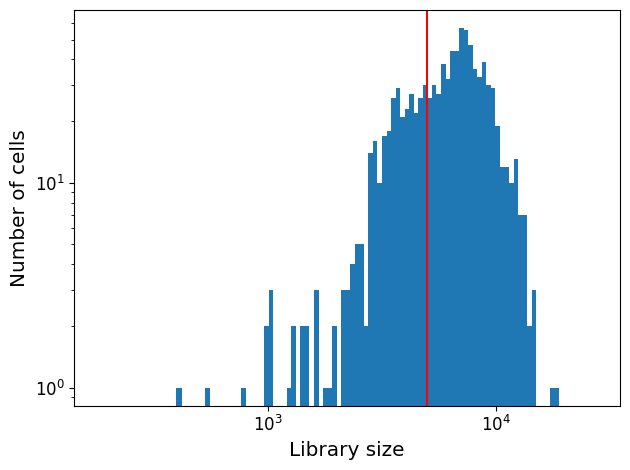

In [56]:
scprep.plot.plot_library_size(sc_train.transpose(), cutoff=5000)

In [57]:
print(sc_train.shape)

(20362, 978)


In [58]:
#sc_pancreas_norm = scprep.normalize.library_size_normalize(sc_pancreas.transpose())
#sc_pancreas_norm = scprep.transform.sqrt(sc_pancreas_norm)

In [59]:
#We will log-transform our data as they evaluate on this kind of data
#sc_train_norm =



### Imputation using MAGIC

In [60]:
magic_op = magic.MAGIC()

In [61]:
train_magic = magic_op.fit_transform(sc_train.transpose())

Calculating MAGIC...
  Running MAGIC on 978 cells and 20362 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 2.69 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.12 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 2.94 seconds.
  Running MAGIC with `solver='exact'` on 20362-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.28 seconds.
Calculated MAGIC in 3.31 seconds.


In [62]:
val_magic = magic_op.transform(sc_val.transpose())

Calculating imputation...


/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


Calculated imputation in 0.25 seconds.


In [63]:
sc_pancreas_metadata.head()

,Sample,Disease,Celltype
Source Name,,,
patient1_A10,patient1,type II diabetes mellitus,acinar cell
patient1_A12,patient1,type II diabetes mellitus,alpha cell
patient1_A13,patient1,type II diabetes mellitus,gamma cell
patient1_A15,patient1,type II diabetes mellitus,gamma cell
patient1_A17,patient1,type II diabetes mellitus,gamma cell


In [64]:
train_magic.head()

Unnamed: 0,NALCN,GUCY1A2,MCM8,PIP4K2A,LINC00898,TSPYL2,DEFA8P,ITPKA,GATA5,GPR75,...,ITGA5,SYCP1,A1BG-AS1,CT47A1,RAE1,C1orf94,GSN,PGM2L1,NUDT16L1,ANKRD20A19P
patient1_A10,0.033799,0.019650,0.154225,1.144430,0.0,0.496676,0.0,0.126979,0.0,0.065716,...,0.426418,0.000000,0.019855,0.0,0.880038,0.000839,1.908237,1.477253,1.306711,0.000000
patient1_A12,0.331301,0.006691,0.096464,0.338620,0.0,1.040646,0.0,0.000062,0.0,0.317245,...,0.009860,0.001959,0.115942,0.0,0.805533,0.000000,0.770576,0.096158,1.242831,0.006385
patient1_A13,0.624642,0.001043,0.085516,0.177040,0.0,1.049276,0.0,0.000023,0.0,0.402714,...,0.004264,0.000070,0.120438,0.0,0.731091,0.000000,1.371877,0.238182,1.129052,0.008644
patient1_A15,0.632395,0.000699,0.077899,0.174479,0.0,1.002442,0.0,0.000010,0.0,0.339703,...,0.003731,0.000080,0.112542,0.0,0.672897,0.000000,1.357011,0.235190,1.086107,0.006507
patient1_A17,0.581366,0.000905,0.089602,0.169411,0.0,0.959081,0.0,0.000006,0.0,0.323665,...,0.006347,0.000384,0.092764,0.0,0.685352,0.000000,1.197667,0.239276,1.020920,0.005899


In [65]:
bulk_train.head()

,patient1,patient2,patient3,patient4
level_0,,,,
NALCN,3.127105,3.012837,3.242790,3.132260
GUCY1A2,2.674861,2.484300,2.781755,2.505150
MCM8,2.374748,2.396199,2.416641,2.523746
PIP4K2A,2.833147,2.889302,2.862728,3.112605
LINC00898,0.000000,0.000000,0.000000,0.000000


In [66]:
#We will create the bulkified matrix to compare the bulk with the imputed data.
#In the bulk matrix we just have one measurement per patient per gene. 
#In the sc data we need to compute the average over each cell for each patient and gene
assert sc_pancreas_metadata.shape[0] == train_magic.shape[0]
train_merged = sc_pancreas_metadata.join(train_magic, on='Source Name')
train_bulkified = train_merged.groupby('Sample', as_index= False).mean().transpose().tail(-1)
train_bulkified.columns = ["patient1","patient2","patient3","patient4"]
train_bulkified.index = sc_train.index 

#We bulkify also the validation dataset
val_merged = sc_pancreas_metadata.join(val_magic, on= 'Source Name')
val_bulkified = val_merged.groupby('Sample', as_index=False).mean().transpose().tail(-1)
val_bulkified.columns = ["patient1","patient2","patient3","patient4"]
val_bulkified.index = sc_val.index 

In [67]:
print(f'Train bulkified matrix shape is : {train_bulkified.shape}')
print(f'Train bulk matrix shape is : {bulk_train.shape}')

Train bulkified matrix shape is : (20362, 4)
Train bulk matrix shape is : (20362, 4)


In [68]:
print(f'Validation bulkified matrix shape is : {val_bulkified.shape}')
print(f'Validation bulk matrix shape is : {bulk_val.shape}')

Validation bulkified matrix shape is : (5091, 4)
Validation bulk matrix shape is : (5091, 4)


In [69]:
#bulkified_magic = sc_pancreas_metadata.join(pancreas_magic, on="Source Name").groupby('Sample', as_index=False).mean().transpose().tail(-1)
#bulkified_magic.columns = ["patient1","patient2","patient3","patient4"]
#bulkified_magic.index = sc_pancreas.index

### Spearman

In [70]:
# MAGIC
corr, pval = spearmanr(bulk_train, train_bulkified)
spearman = corr.mean()
print(f'Spearman correlation for train is {spearman}')

corr_val, pval_val = spearmanr(bulk_val, val_bulkified)
spearman_val = corr_val.mean()
print(f'Spearman correlation for validation is {spearman_val}')

Spearman correlation for train is 0.9584617688692529
Spearman correlation for validation is 0.9570258871973059


In [ ]:
#TODO: train magic with all the train data, predict on test and provide the file in the final format
#We need to log transform the data

# Step 2: Perform clustering 

### Clustering on MAGIC transformed data

In [16]:
# Perform t-SNE dimensionality reduction on not imputed data.
#For t-sne I think we need to transpose the data because we are interested in patient cells and not on all the genes. 
#Right now what is happening is that it is keeping all the genes but reducing the patient cells
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
train_tsne = tsne.fit_transform(sc_pancreas_shuff.transpose())

In [17]:
print(sc_pancreas_shuff.transpose().head())

Unnamed: 0      CCDC59  SLC25A43     SCN3A  FBXO39  LOC494141  TEDDM1   BTBD6  \
patient1_A10  0.301030  0.000000  0.000000     0.0    0.00000     0.0  0.0000   
patient1_A12  0.845098  0.000000  0.000000     0.0    0.00000     0.0  0.0000   
patient1_A13  0.000000  0.000000  1.544068     0.0    0.30103     0.0  2.1959   
patient1_A15  0.000000  0.000000  0.000000     0.0    0.00000     0.0  0.0000   
patient1_A17  0.000000  1.079181  1.079181     0.0    0.00000     0.0  0.0000   

Unnamed: 0    SLC25A40  MIR4731  MIR384  ...     BRAP  MIR8082  TMEM38A  \
patient1_A10  0.000000      0.0     0.0  ...  0.00000      0.0      0.0   
patient1_A12  1.518514      0.0     0.0  ...  2.08636      0.0      0.0   
patient1_A13  0.000000      0.0     0.0  ...  0.00000      0.0      0.0   
patient1_A15  1.591065      0.0     0.0  ...  0.00000      0.0      0.0   
patient1_A17  0.000000      0.0     0.0  ...  0.00000      0.0      0.0   

Unnamed: 0      SLC1A1     PHPT1   CASKIN2  KCNMB3     AGMAT  

In [18]:
print(sc_pancreas_shuff.transpose().shape)

(978, 25453)


In [19]:
print(sc_pancreas_metadata.head())

                Sample                    Disease     Celltype
Source Name                                                   
patient1_A10  patient1  type II diabetes mellitus  acinar cell
patient1_A12  patient1  type II diabetes mellitus   alpha cell
patient1_A13  patient1  type II diabetes mellitus   gamma cell
patient1_A15  patient1  type II diabetes mellitus   gamma cell
patient1_A17  patient1  type II diabetes mellitus   gamma cell


In [20]:
print(train_tsne.shape)
print(f'I have {len(sc_pancreas_metadata["Celltype"].unique())} different cell types, so I will have these cluster labels')

(978, 2)
I have 13 different cell types, so I will have these cluster labels


In [21]:
cell_labels = sc_pancreas_metadata['Celltype']
encoder = LabelEncoder()
encoded_label = encoder.fit_transform(cell_labels)
decoded_label = encoder.inverse_transform(encoded_label)

In [22]:
#Check that the encoded labels match with the real labels and that we have the same number of them
decoded_set = set(np.ndarray.tolist(decoded_label))
df = pd.DataFrame(encoded_label)
print(df.iloc[:,0].value_counts())
print(sc_pancreas_metadata['Celltype'].value_counts())


3     378
7     160
10    124
2     119
4      91
6      29
1      26
5      17
12     15
8      10
9       5
0       2
11      2
Name: 0, dtype: int64
alpha cell                     378
ductal cell                    160
gamma cell                     124
acinar cell                    119
beta cell                       91
delta cell                      29
PSC cell                        26
co-expression cell              17
unclassified endocrine cell     15
endothelial cell                10
epsilon cell                     5
MHC class II cell                2
mast cell                        2
Name: Celltype, dtype: int64


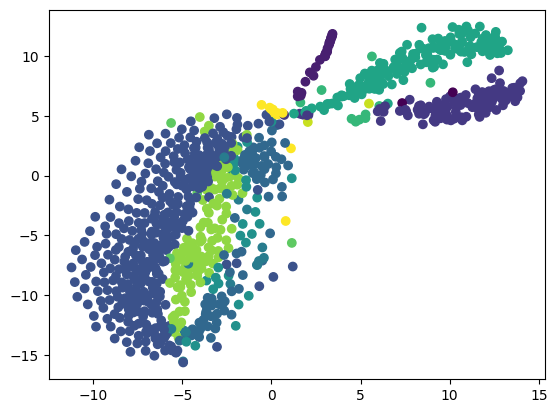

In [23]:
fig, ax = plt.subplots()
count=0
""""
for color in zip(encoded_label):
    x= train_tsne[count, 0]
    y = train_tsne[count, 1]
    ax.scatter(x,y,c= color[0])
    count +=1
#plt.scatter(train_tsne[:,0], train_tsne[:,1], c=encoded_label)
ax.legend(decoded_set)
"""
scatter = ax.scatter(train_tsne[:,0], train_tsne[:,1], c= encoded_label, label = encoded_label)

In [24]:
# Perform K-means clustering
#TODO: Change clustering method
kmeans = KMeans(n_clusters=13, random_state=42)
clusters = kmeans.fit_predict(train_tsne) # TODO: Add the +1 in the end not now

/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
print(clusters.shape)
print(train_tsne.shape)
print(set(np.ndarray.tolist(clusters)))
print(set(np.ndarray.tolist(encoded_label)))
#The number of clusters is 12 as expected
#TODO: how to change back to the cell type labels
print(decoded_label.shape)

(978,)
(978, 2)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
(978,)


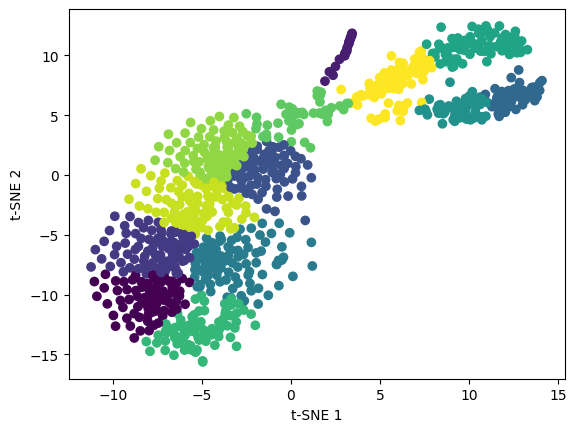

In [26]:
# Plot t-SNE visualization with cluster assignments
plt.scatter(train_tsne[:,0], train_tsne[:,1], c=clusters)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [27]:
cluster_labels = pd.DataFrame(data = {'index': sc_pancreas.columns, 'cluster': clusters})
cluster_labels

,index,cluster
0,patient1_A10,4
1,patient1_A12,2
2,patient1_A13,5
3,patient1_A15,5
4,patient1_A17,11
...,...,...
973,patient4_P5,10
974,patient4_P6,11
975,patient4_P7,8
976,patient4_P8,8


### PCA

In [28]:
pca = PCA(n_components=50)
pancreas_pca = pca.fit_transform(sc_pancreas_shuff.transpose()) #TODO: check if this is what they mean

In [29]:
# Print the explained variance ratio for each principal component
# print('Explained variance ratio:', pca.explained_variance_ratio_)

# Print the total explained variance
print('Total explained variance:', np.sum(pca.explained_variance_ratio_))

Total explained variance: 0.38842654061572335


In [30]:
PCA_df = pd.DataFrame(data = pancreas_pca, columns = ["PC"+str(i+1) for i in range(50)])
print(PCA_df.shape)
PCA_df.insert(loc=0, column='index', value=sc_pancreas_shuff.columns)
print(PCA_df)

(978, 50)
            index        PC1        PC2        PC3       PC4        PC5  \
0    patient1_A10  40.489302 -22.230796   9.974890  8.454234  -6.588392   
1    patient1_A12   7.670247  25.574993   6.115141  1.295697  -9.428235   
2    patient1_A13   2.777072  17.943410  -3.727847 -3.864339  12.042831   
3    patient1_A15  -5.529352  15.338925  -1.530467 -3.364027  10.358201   
4    patient1_A17 -11.549877  12.305206  -7.614409 -6.619075   8.590641   
..            ...        ...        ...        ...       ...        ...   
973   patient4_P5 -43.536287  -7.582625 -11.671886 -6.385238  -0.133102   
974   patient4_P6 -24.150868   0.470084 -11.728410 -6.437746  -3.862058   
975   patient4_P7  32.410461  22.263998 -11.705317 -4.941203  -4.621401   
976   patient4_P8  72.454097  37.595868 -12.003503 -3.440000  -8.141996   
977   patient4_P9 -31.959218  -2.129329 -14.390317 -7.377908  -1.575815   

           PC6        PC7        PC8       PC9  ...      PC41      PC42  \
0   -12.239739

### Evaluation metrics

In [31]:
#true_labels = LabelEncoder().fit(sc_pancreas_metadata['Celltype'])
#true_labels = true_labels.transform(sc_pancreas_metadata['Celltype'])
#true_labels # NO SE PORQUE PERO ESTO ME DA 12 CLASES en vez de 11
true_labels = encoded_label

In [32]:
ssc = silhouette_score(pancreas_pca, clusters)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(true_labels, clusters)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(true_labels, clusters)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

Silhouette score: 0.08646713542393643
Adjusted Rand Index: 0.28351135337142547
V-Measure score: 0.5510600732836547
Performance: 0.3070128540263388


Scanpy tutorial for clustering

In [55]:
sc_pancreas = sc.read(os.path.join(path_data,"train_data","pancreas_sc_train.csv"))
sc_pancreas.var['cell_type'] = sc_pancreas_metadata['Celltype']

In [56]:
sc_pancreas.var_names_make_unique()

In [57]:
sc.pp.normalize_total(sc_pancreas, target_sum=1e4)
sc.pp.log1p(sc_pancreas)
sc_pancreas.raw = sc_pancreas

/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [58]:
sc.tl.pca(sc_pancreas, svd_solver='arpack')

In [59]:
sc.pp.neighbors(sc_pancreas, n_neighbors=10, n_pcs=50)

In [62]:
sc.tl.umap(sc_pancreas)

/home/pballesteros/miniconda3/envs/ML4G_Proj2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


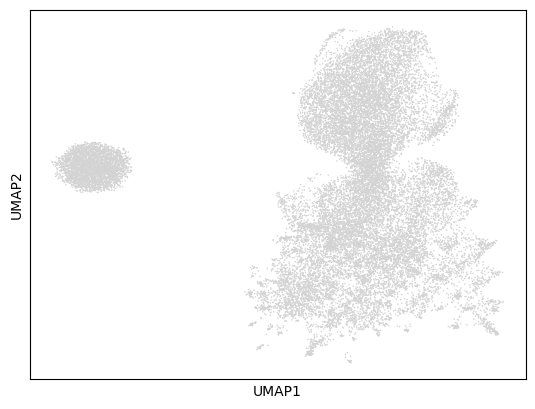

In [39]:
#sc.pl.umap(sc_pancreas,use_raw=False)

In [65]:
labels = sc.tl.leiden(sc_pancreas, resolution =0.40005)

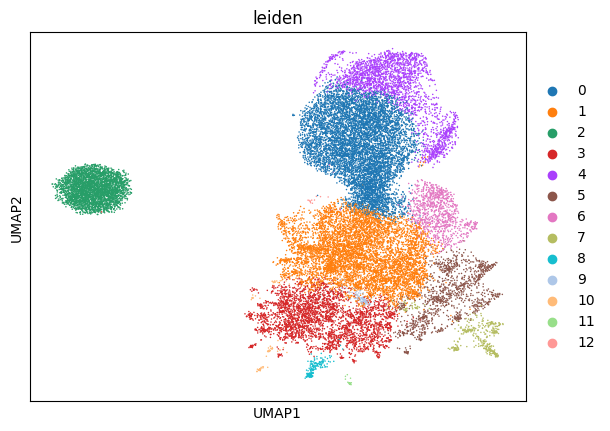

In [66]:
sc.pl.umap(sc_pancreas, color=['leiden'])

In [67]:
pca = PCA(n_components=50)
pancreas_pca = pca.fit_transform(sc_pancreas) #TODO: check if this is what they mean
PCA_df = pd.DataFrame(data = pancreas_pca, columns = ["PC"+str(i+1) for i in range(50)])
PCA_df.insert(loc=0, column='index', value=sc_pancreas_shuff.columns)

KeyboardInterrupt: 

In [69]:
print(labels)

None


In [ ]:
true_labels= encoded_label

ssc = silhouette_score(pancreas_pca, clusters)
print('Silhouette score:', ssc)

ari = adjusted_rand_score(true_labels, clusters)
print('Adjusted Rand Index:', ari)

v_measure = v_measure_score(true_labels, clusters)
print('V-Measure score:', v_measure)

performance = (1/3)*(ssc + ari + v_measure)
print('Performance:', performance)

# Step 3: Predict on the test data

Cuando decidamos qué tecnicas de imputación y clustering son mejores, hacerlo en los datos de test.

# Step 4: Save the required files

In [ ]:
# bulkified should be a DataFrame containing the "bulkified" version of the imputed data
# bulkified.columns = ["patient5","patient6","patient7"]
# bulkified.index = sc_pancreas_test.index

In [ ]:
# assert all(bulkified.columns == ["index","patient5","patient6","patient7"])
# assert all(bulkified["index"] == sc_pancreas_test.index)

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = sc_pancreas_test.columns

In [ ]:
# assert all(cluster_labels.columns == ["index","cluster"])
# assert all(cluster_labels["index"] == sc_pancreas_test.columns)

In [ ]:
# PCA should be a DataFrame containing the coordinates of each cell in the PCA transformed space for the 50 first PCs
# PCA.columns = ["index", "PC1", "PC2", ..., "PC50"]
# PCA["index"] = sc_pancreas_test.columns

In [ ]:
# assert all(PCA.columns == ["index"] + ["PC"+str(i+1) for i in range(50)])
# assert all(PCA["index"] == sc_pancreas_test.columns)

In [ ]:
# with zipfile.ZipFile(os.path.join(results_path, archive_name), "x") as zf:
#     with zf.open(f"imputed_bulkified.csv", "w") as buffer:
#         bulkified.to_csv(buffer)
#     with zf.open(f"cluster_membership.csv", "w") as buffer:
#         cluster_labels.to_csv(buffer)
#     with zf.open(f"PCA.csv", "w") as buffer:
#         PCA.to_csv(buffer)
#     zf.close()

In [ ]:
# archive = zipfile.ZipFile(os.path.join(results_path, archive_name))
# assert all(
#         [
#             i in archive.namelist()
#             for i in [
#                 "imputed_bulkified.csv",
#                 "cluster_membership.csv",
#                 "PCA.csv",
#             ]
#         ]
#     )